In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score,precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack


In [2]:
wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed_weather_labeled.csv", index_col=0) 
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]
wine_base.columns

Index(['vintage', 'country', 'description', 'points', 'price', 'province',
       'region_1', 'taster_name', 'variety', 'winery',
       'similarityTop3WinesByVariety', 'word_count', 'tf_grouped_1',
       'tf_grouped_2', 'tf_grouped_3', 'tfIdf_grouped_1', 'tfIdf_grouped_2',
       'tfIdf_grouped_3', 'tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',
       'tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3', 'pr_5',
       'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8',
       'tas_9'],
      dtype='object')

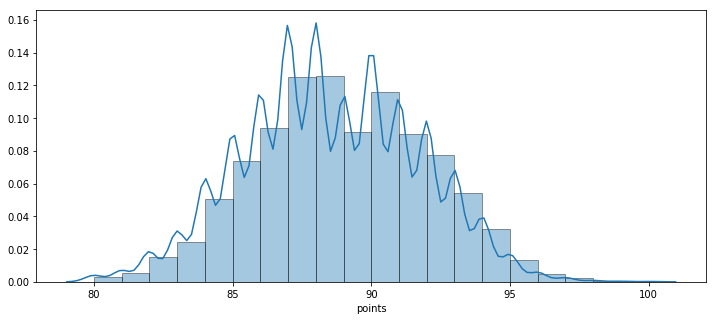

In [3]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.distplot(wine_base["points"],hist=True,bins = 20,hist_kws={'edgecolor':'black'})

# DEFINE NUMBER OF BINS = classes to be predicted (must be executed so that Y is the same for every execution)

In [4]:
Y = wine_base['points'].copy()
#DECIDE NUMBER OF BINS 
#nbins  = 4
#labels=["low","medium","high","very_high"]
#nbins = 5
#labels=["very_low", "low", "medium","high","very_high"]
#bin identici 
#Y,bins = pd.cut(Y,nbins,labels=labels,retbins=True,include_lowest=True,right=True)
#quartile
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
values = Y.tolist()  
bins

array([ 80.,  87.,  90., 100.])

10.0


<module 'seaborn' from '/home/simone/Documents/univerista/Magistrale/BDA/venv/lib/python3.6/site-packages/seaborn/__init__.py'>

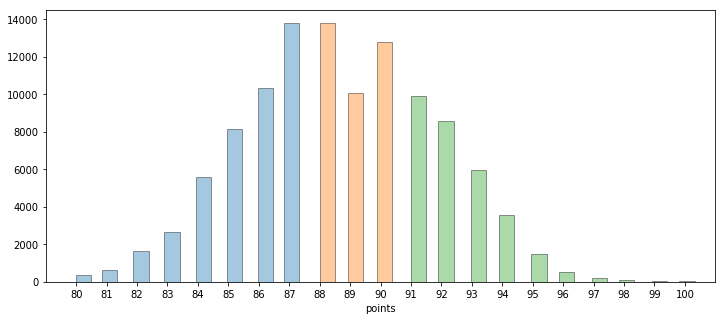

In [5]:
#plot the binning result
fig, ax = plt.subplots(figsize = (12, 5))
for i in range(1,len(bins)-1):

    if i == 1:
        a = wine_base[wine_base["points"] <= bins[i]]
        n =  bins[i]-80
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+n
    if i == len(bins)-1:
        a = wine_base[wine_base["points"] > bins[i]]
        n = 100 - bins[i]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+ n
    else:
        n = bins[i+1] - bins[i]
        g =+n
        a = wine_base[(wine_base["points"] > bins[i]) & (wine_base["points"] <= bins[i+1])]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
ax.set(xticks=wine_base["points"].unique())
print(g)
sns

In [6]:
basic = ["price",'vintage', 'country', 'province', 'region_1', 'taster_name', 'variety','winery']
word = ["word_count"]
tfGroup = ['tf_grouped_1','tf_grouped_2', 'tf_grouped_3']
tfIdfGroup = ['tfIdf_grouped_1', 'tfIdf_grouped_2', 'tfIdf_grouped_3']
tfFull = ['tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',]
tfIdfFull = ['tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3']
#weather = ['pr_5', 'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8', 'tas_9']# don't really care bcs 0 improvements
word2vec = ['similarityTop3WinesByVariety']
features = basic + word + tfGroup + word2vec

# DUMMY CLASSIFIER = BASELINE

In [7]:
X = wine_base.loc[:,features]
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
classifier = DummyClassifier("stratified")
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)  
acc = accuracy_score(y_test,y_pred)
weightedPrec = precision_score(y_test,y_pred,average="weighted")
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

         low       0.28      0.28      0.28      9112
      medium       0.39      0.39      0.39     12828
        high       0.33      0.33      0.33     11070

   micro avg       0.34      0.34      0.34     33010
   macro avg       0.33      0.33      0.33     33010
weighted avg       0.34      0.34      0.34     33010



# CLASSIFIER WITHOUT SPARSE MATRIX

In [ ]:
def decTree(features, depth, data):
    X = data.loc[:,features]
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    classifier = DecisionTreeClassifier(max_depth=depth)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)  
    acc = accuracy_score(y_test,y_pred)
    weightedPrec = precision_score(y_test,y_pred,average="weighted")

    #get feature importances
    lista = []
    for name, importance in zip(features, classifier.feature_importances_):
        lista.append([name, importance])
    precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred,labels=labels)
    print(classification_report(y_test, y_pred, target_names=labels))
    return classifier

In [ ]:
features = ["price","vintage"] #basic + word2vec + word_count...
depth = 4
clf = decTree(features,depth,wine_base)

In [ ]:
#show me the tree

##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed
import os
import sys
def conda_fix(graph):
        path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)
import pydotplus 
from sklearn import tree
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

# Classifier using sparse matrix

In [ ]:
def sparseMatrixRep(features,depth,data,test_size):
    X = data.loc[:,features+["description"]]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    #compute countvectorizer
    vect = CountVectorizer(min_df=5)
    vect.fit(X_train['description'])
    print("vocabulary size: {}".format(len(vect.vocabulary_)))
    X_train_vectored_cv = vect.transform(X_train['description'])
    X_train_final = X_train_vectored_cv
    for feature in features:
        X_train_final = hstack((X_train_final,np.array(X_train[feature])[:,None]))
    
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train_final, y_train)
    
    y_train_pred = clf.predict(X_train_final)
    X_test_final = vect.transform(X_test['description'])
    for feature in features:
        X_test_final = hstack((X_test_final,np.array(X_test[feature])[:,None]))

    y_test_pred = clf.predict(X_test_final)
    print(classification_report(y_test, y_test_pred, target_names=labels))
    
    return clf

In [ ]:
#change the input and compute

features = ["price"] #basic #+ word + tfGroup + word2vec
depth = 3
test_size = 0.30
clf = sparseMatrixRep(features,depth,wine_base,test_size)

In [ ]:
#show me the tree
##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed

import os
import sys
import pydotplus 
from sklearn import tree
from IPython.display import Image  

def conda_fix(graph):
    path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
    paths = ("dot", "twopi", "neato", "circo", "fdp")
    paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
    graph.set_graphviz_executables(paths)
    
dot_data = tree.export_graphviz(clf, out_file=None,   
                             class_names=labels,  
                             filled=True, rounded=True,  
                             special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

# Test with combinations and get results dataframe (no countvect working on this as of now)

In [ ]:
#create a dataframe with every test combination you put
def testToDataFrame(algorithm,combination,Y,allfeats,dataset):
    test_size = 0.30 
    cols = ["algorithm","input","precision","accuracy","depth"]
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in allfeats: #controlla che allfeats vada bene, amgari fotte con l'ordine
        cols.append("feat_"+el)
    results = pd.DataFrame()
    row = 0
    comb = 0
    for el in combination["args"]: 
        for depth in combination["depth"]:
            row = row + 1
            X = dataset.loc[:,el]
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
            if algorithm == "decTree":
                classifier = DecisionTreeClassifier(max_depth=depth)
            else:
                classifier = RandomForestClassifier(max_depth=depth,n_estimators = estimators)
            classifier.fit(X_train,y_train)
            y_pred = classifier.predict(X_test)  
            acc = accuracy_score(y_test,y_pred)
            weightedPrec = precision_score(y_test,y_pred,average="weighted")        
            data = [algorithm,el,weightedPrec,acc,depth]
            precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
            for i in range(0,len(labels)):
                data.append(precision[i])
                data.append(recall[i])
                data.append(fscore[i])
                data.append(support[i])
            #for lab in labels:
            
             #   data.append(rep[lab].precision)     #ORDER IS VERY IMPORTANT
              #  data.append(rep[lab].recall)
               # data.append(rep[lab].f1-score)
                #data.append(rep[lab].support)
            temp = {}
            c = zip(el,classifier.feature_importances_)
            for name,importance in c:
                temp[name] = importance
            for feat in allfeats:
                if feat not in el:
                    data.append(100) #100 is an impossible value not to be taken into account
                else:
                    data.append(temp[feat])
            df2 = pd.DataFrame([data],columns=cols)
            results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [ ]:
args = [["price"],["price","word_count"],basic,basic+tfGroup, basic+word2vec,basic+word2vec+tfGroup,word2vec,tfGroup,word2vec+tfGroup]
allfeatures = basic + word + word2vec + tfGroup 
decTreeCombinations = {"depth":[2,3,4,5],"args":args}

In [ ]:
res = testToDataFrame("decTree",decTreeCombinations,Y,allfeatures,wine_base)

In [ ]:
res.sort_values(["precision",'depth'],ascending=False)

In [ ]:
res.iloc[19]

In [ ]:
res.iloc[17]